In [1]:
import pandas as pd

In [2]:
food_orders = pd.read_csv('food_orders_new_delhi.csv')

In [3]:
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [4]:
food_orders.columns

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks'],
      dtype='object')

In [5]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [6]:
pd.set_option('display.max.rows', 1000)
pd.set_option('display.max.columns', 12)

In [7]:
pd.isnull(food_orders).sum()

Order ID                    0
Customer ID                 0
Restaurant ID               0
Order Date and Time         0
Delivery Date and Time      0
Order Value                 0
Delivery Fee                0
Payment Method              0
Discounts and Offers      185
Commission Fee              0
Payment Processing Fee      0
Refunds/Chargebacks         0
dtype: int64

In [8]:
food_orders.dropna(inplace=True)

pd.isnull(food_orders).sum()

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
dtype: int64

### Convert "Order Date and Time" and "Delivery Date and Time" to datetime format
### Convert “Discounts and Offers” to a consistent numeric value or calculate the discount amounts
### Ensure all monetary values are in a suitable format for calculations

In [9]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

# apply the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head())

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
4         1992         50 off Promo                 50.0           996.00
5          439                  10%                 10.0            43.90


In [10]:
print(food_orders.dtypes)

Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount                  float64
dtype: object


## Cost Analysis 
> Delivery Fee

> Payment Processing Fee

> Discount Amount 

In [11]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']

food_orders['Revenue'] = food_orders['Commission Fee']

food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']


In [12]:
# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders" : total_orders,
    "Total Revenue" : total_revenue,
    "Total Costs" : total_costs,
    "Total Profit" : total_profit
}

print(overall_metrics)

{'Total Orders': 815, 'Total Revenue': np.int64(103798), 'Total Costs': np.float64(221741.84999999998), 'Total Profit': np.float64(-117943.84999999998)}


### Based on the analysis,
> Total orders : 815  /1000

> Total Revenue (from commission fees): 103,798 INR  /126990

>Total Costs : 221,741.84999999998 (including delivery fees, payment processing fees and discounts)       /232,709.85

>Total Profit : -117,943.84999999998 INR       /-105719.85

### From the numbers, we can see that total costs exceeds the total revenue generated from the commission fees, resulting in net loss!
Therefore, the current commission rates, delivery fees and discount strategies might not be sustainable for profitability.


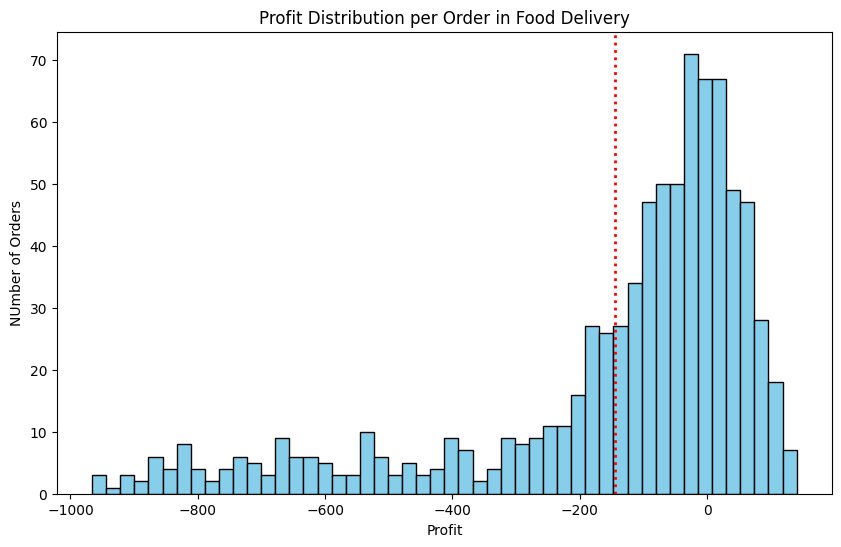

In [13]:
# Lets plot a histogram of profits per order to visualize
# the distribution of profitable and unprofitable orders
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('NUmber of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dotted', linewidth=2)
plt.show()

The histogram shows that most of the profits per order are below 0, resulting in a loss.
The dotted line indicates the average(mean) profit, which is in negative territory, highlighting the *overall loss-making situation*.

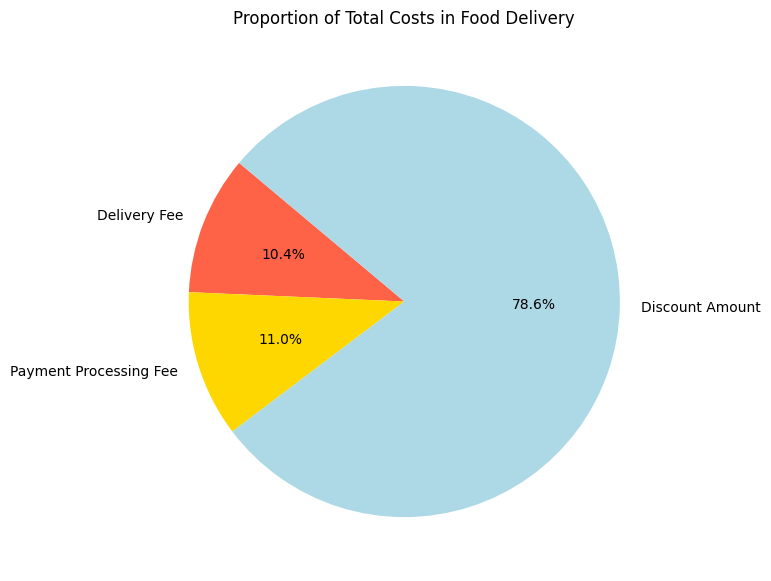

In [14]:
# Lets make a pie chart to visualize the 
# proportion of total costs(delivery fees, payment processing and discounts)

costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()

plt.figure(figsize=(7,7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct = '%1.1f%%', startangle=140, colors=['tomato','gold','lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()


From the pie chart we can see that discounts constitute a significant 
portion of the costs, suggesting that promotional strategies might be heavily 
impacting overall profitability.

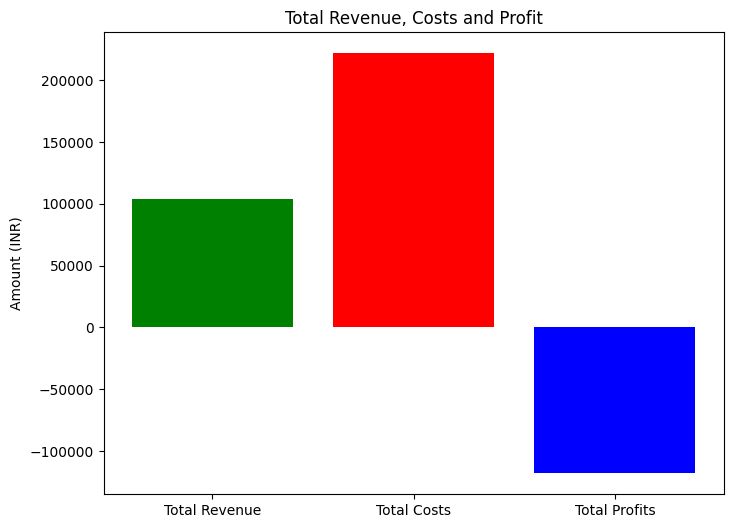

In [15]:
# Now we compare the total revenue, total costs and total profit
# We plot a bar chart for the above

totals = ['Total Revenue', 'Total Costs','Total Profits']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8,6))
plt.bar(totals,values, color=['green','red','blue'])
plt.title("Total Revenue, Costs and Profit")
plt.ylabel("Amount (INR)")
plt.show()

The bar chart clearly shows that the costs surpass the revenue, leading to a total loss.

# A New Strategy for Profits

We need to find a new strategy for profitability. 
To find a sweet spot between commission and discount percentages, we can analyze the characteristics of profitable orders more deeply.
For this, we specifically look for
>  A new average commission percentage based on profitable orders

> A new average discount percentage for profitable orders, that could serve as a guideline for what level of dsicount still allows for profitability.

In [19]:
# we calculate avg commission for profitable orders and avg discount percentage for profitable orders

# filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0]

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for the profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100


# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()


print(new_avg_commission_percentage, new_avg_discount_percentage)


36.99030453177021 9.938775510204081


C:\Users\tushh\AppData\Local\Temp\ipykernel_13828\1119285120.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100
C:\Users\tushh\AppData\Local\Temp\ipykernel_13828\1119285120.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100


>> New Average Commission Percentage: 36.99 %

>> New Average Discount Percentage: 9.93 %

### Based on this analysis, a strategy that aims for a commission rate closer to 35% and a discount rate around 6% could potentially improve profitability across the board.

Now, let's visualize a comparison of profitability using actual versus recommended discounts and commissions across all orders.

For this, we 
1. Calculate the profitability per order using the actual discounts and commissions already present in the dataset.
2. Simulate profitability per order using the recommended discounts and commissions to see the potential impact on profitability.

In [21]:
# Visualizing the comparison between recommended discount and commission rates on overall 
# profitability of orders.

# calculate the simulated commission fee and discount amount using recommended discounts and commissions

recommended_commission_percentage = 35.0 #35%
recommended_discount_percentage = 10.0 #10%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage /100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])



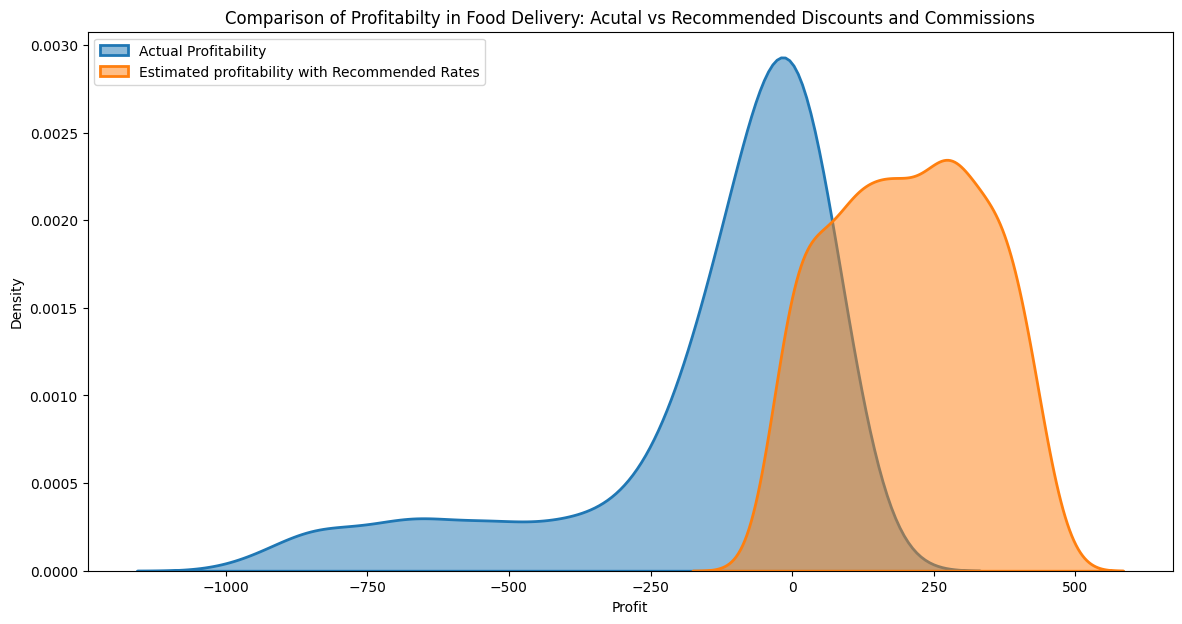

In [23]:
# visualize the comparison
import seaborn as sns

plt.figure(figsize=(14,7))

# actual profitability 
sns.kdeplot(food_orders['Profit'], label = 'Actual Profitability', fill = True, alpha=0.5, linewidth=2)

# simulated profitability 
sns.kdeplot(food_orders['Simulated Profit'], label = 'Estimated profitability with Recommended Rates',fill = True, alpha=0.5, linewidth=2)

plt.title( 'Comparison of Profitabilty in Food Delivery: Acutal vs Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc = 'upper left')
plt.show()


The above vizualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts and commissions.

The simulated distribution suggests a shift towards higher profitability per order. The distributiion is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.